# Testing Different k-fold Sizes for 30 Days of ML Challenge

We are going to evaluate different k-fold sizes to check if performance increases before doing any kind of optimization:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For one-hot encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

# For the construction of the pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For training the XGBoost model
from xgboost import XGBRegressor

# For the mean squared error needed to calculate our scores
from sklearn.metrics import mean_squared_error

# For keeping the time
import time

# For graphing
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_20_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_50_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_15_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_30_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_5_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_25_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_10_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_12_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_60_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_40_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_3_folds.csv
/kaggle/input/train-folds-k-folds-30-days-of-ml/train_folds_6_folds.csv


In [2]:
# We set up a dictionary that will store the fold number as a key and the RMSE as a value: 
fold_results = dict()

In [3]:
# We set the fold numbers
fold_nums = [3, 5, 6, 10, 12, 15, 20, 25, 30, 40, 50, 60]

# We set a for loop to loop across all fold numbers
for fold_num in fold_nums:

    # We start a timer
    start_time = time.clock()

    # Load the training and test data. 
    X_full = pd.read_csv("../input/train-folds-k-folds-30-days-of-ml/train_folds_" + str(fold_num) +"_folds.csv")
    X_test_full = pd.read_csv("../input/30-days-of-ml/test.csv")

    # We select all features except "id", "target" and "kfold", as these are not predictors of our target.
    useful_features = [c for c in X_full.columns if c not in ("id", "target", "kfold")]

    # We select categorical columns. Note that we dropped the cardinality check.
    object_cols = [col for col in useful_features if 'cat' in col]

    # We build X_test out of X_test_full, but only selecting the useful features.
    X_test = X_test_full[useful_features]

    # Next up, we set up the for loop which will perform the target encoding:
    for col in object_cols: 
        temp_X_full = [] # We create a temporary list to store the dataframes.
        temp_test_feature = None # We create a temporary feature for the test set.

        for fold in range(fold_num): # We loop across all folds
            X_train = X_full[X_full.kfold != fold].reset_index(drop=True) 
            X_valid = X_full[X_full.kfold == fold].reset_index(drop=True) 
            feat = X_train.groupby(col)["target"].agg("mean") # We group the columns by target, and then we get the mean value of the values in "target" column.
            feat = feat.to_dict() # We convert the dataframe into a dictionary.
            X_valid.loc[:, f"tar_enc_{col}"] = X_valid[col].map(feat) # We map the mean values to a new column in X_valid.
            temp_X_full.append(X_valid) # We append X_valid to our temporary list.

            if temp_test_feature is None: # If we don't have a temp_test_feature...
                temp_test_feature = X_test[col].map(feat) # ...we assign it this value.

            else: # If its not None, (for folds above 0)...
                temp_test_feature = temp_test_feature + X_test[col].map(feat) # ...add to it the present value.

        temp_test_feature = temp_test_feature/fold_num # We divide by the number of folds to get the average.
        X_test.loc[:, f"tar_enc_{col}"] = temp_test_feature # We assign the temp_test_feat value to a new column.
        X_full = pd.concat(temp_X_full) # We build the new X_full dataframe with the new target encoding columns.

    # We select all features except "id", "target" and "kfold", as these are not predictors of our target.
    useful_features = [c for c in X_full.columns if c not in ("id", "target", "kfold")]

    # Select numerical columns by data type, not by column name
    num_cols = [col for col in X_full[useful_features] if X_full[col].dtype in ['int64', 'float64']]

    # We select categorical columns. Note that we dropped the cardinality check.
    object_cols = [col for col in useful_features if col.startswith("cat")]

    # Preprocessing for numerical data, we use a StandardScaler to apply standardization.
    numerical_transformer = preprocessing.StandardScaler()

    # Preprocessing for categorical data and one-hot encoding.
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),('cat', categorical_transformer, object_cols)])

    # Define the model 
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0, predictor="gpu_predictor")

    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])


    # We set up a list to store the final predictions.
    final_predictions = []

    # We set up a list for storing the mean non squared error scores.
    scores = []

    # We set the loop to loop across all of the folds.
    for fold in range(fold_num):
        X_train = X_full[X_full.kfold != fold].reset_index(drop=True) # We set the training data to be all folds different from the current fold number in the loop. We also reset the indices.
        X_valid = X_full[X_full.kfold == fold].reset_index(drop=True) # The validation data is the current fold number in the loop. We also reset the indices.
        X_test_copy = X_test.copy() # We copy the original X_test to not alter or overwrite over it.

        y_train = X_train.target # We set the training target equal to the target in the training set. This has to be done every iteration (as the fold and the data changes).
        y_valid = X_valid.target # We set the validation target equal to the target in the validation set. This has to be done every iteration (as the fold and the data changes).

        X_train = X_train[useful_features] # We set our training data to be the previously defined useful features of X_train.
        X_valid = X_valid[useful_features] # We set our validation data to be the previously defined useful features of X_valid.

        # We activate the pipeline, which preprocesses the training data and fits the model (will take about 10 minutes to run)
        my_pipeline.fit(X_train, y_train)

        preds_valid = my_pipeline.predict(X_valid) # We instruct the pipeline to make predictions on X_valid.
        preds_test = my_pipeline.predict(X_test) # We instruct the pipeline to make predictions on X_test.
        final_predictions.append(preds_test) # We append each of the test predictions on to our final_predictions list.
        rmse = mean_squared_error(y_valid, preds_valid, squared=False) # We store the mean non squared error in a variable.
        print(fold, rmse) # Print the fold number, and the mean non squared error for each fold.
        scores.append(rmse) # We append the rmse value to the scores list.

    print(np.mean(scores), np.std(scores)) # Print the mean non square error average, and its standard deviation

    print(time.clock() - start_time, "seconds") # We print the elapsed time.

    fold_results[str(fold_num) + " Folds"] = np.mean(scores) # We append the mean score with a key to the dictionary.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.726240273778108
1 0.7288563477487658
2 0.7380693750098901
0.7310553321789213 0.005073365640347451
19.293560999999997 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7227030406324084
1 0.7306875651326146
2 0.7264380957570341
3 0.7285041616809392
4 0.7446395076435606
0.7305944741693114 0.007499216522979915
29.404221 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.724347082554987
1 0.7248725007929738
2 0.7313931672527008
3 0.7231091976428798
4 0.7293228498533855
5 0.7863747914497826
0.7365699315911183 0.022462051080777617
34.735527000000005 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7216500566497908
1 0.7226179799873971
2 0.7266011252543036
3 0.7526592732650232
4 0.7268943391996648
5 0.7255378853166236
6 0.7237888891048
7 0.7268900014297455
8 0.7216664118432697
9 0.7219362759657763
0.7270242238016393 0.008791679424357579
56.848594000000006 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.72486127042736
1 0.7227939061244889
2 0.7216171088433959
3 0.7293938669346249
4 0.7342210353529476
5 0.7274793389698482
6 0.7241330562833703
7 0.7222636126733094
8 0.7931364829200374
9 0.7207233150706803
10 0.7206087761883729
11 0.7203987220644685
0.7301358743210753 0.019407577172361808
68.51995599999998 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7250686711162421
1 0.721032309461783
2 0.7206892792486921
3 0.7281308319261918
4 0.7264377441335658
5 0.7364385768430419
6 0.7249966374030415
7 0.7259483377834172
8 0.7277411641672034
9 0.7202896428534751
10 0.7640276518087451
11 0.7257135166397704
12 0.7235665951902892
13 0.7178149120108698
14 0.7210648745973834
0.727264049678914 0.010719402669073569
85.98684 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7247959246298631
1 0.7189214022745
2 0.7261883016891576
3 0.7186873826446438
4 0.7242490775641568
5 0.7299728536649883
6 0.7315720345005431
7 0.737420180177257
8 0.7230922131215075
9 0.7289096632324976
10 0.7214720264803933
11 0.7277783405098667
12 0.7191597921166464
13 0.7273177792582529
14 0.7370701565153659
15 0.7200332777868793
16 0.7233297395775672
17 0.7202020738613919
18 0.7156858919493768
19 0.7210264085172221
0.7248442260036039 0.005821479565386137
115.66376100000002 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7262820770761391
1 0.7210503405523593
2 0.719625018241032
3 0.7249039362413777
4 0.7180130897291278
5 0.7199612618303323
6 0.733916076652264
7 0.7234594684685326
8 0.7394789069971728
9 0.7346413300152903
10 0.7260694073932337
11 0.7227394165417289
12 0.7247713267231858
13 0.7274679789719131
14 0.7290454208085593
15 0.7166850646699696
16 0.7242900245747437
17 0.739111148537091
18 0.7307904012354525
19 0.721140407751213
20 0.7217517584628854
21 0.7235993844898044
22 0.7154919847364599
23 0.7207183602659406
24 0.7202799951836707
0.7250113434459791 0.006306472530876451
143.29923100000002 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7253754851730413
1 0.724272658389499
2 0.7147678493146344
3 0.724336728870372
4 0.728894030294253
5 0.7146256542474092
6 0.7217916012785829
7 0.7340576603575958
8 0.7238582146686081
9 0.7262593671713699
10 0.7403424853052444
11 0.7376328060518879
12 0.7218115172538129
13 0.7259028407919658
14 0.728677564947701
15 0.7190747980316566
16 0.725565366562466
17 0.7294782148144355
18 0.7170170088536076
19 0.7230376374144105
20 0.7297154829755073
21 0.7365987665222933
22 0.7282952154191471
23 0.7195959299899604
24 0.7205083191214696
25 0.7247478701472042
26 0.7220180063326573
27 0.7142323107371459
28 0.7163647328533875
29 0.7272618407119635
0.7248705988201097 0.006550964373399811
170.25196700000004 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7236294674225684
1 0.7253405959500994
2 0.7219184418660667
3 0.7116633760285356
4 0.726690498203086
5 0.7255961202129274
6 0.7258474965587285
7 0.7140296597180875
8 0.713411882470135
9 0.7353557327229859
10 0.735932702993489
11 0.7230282391421144
12 0.7259009003277438
13 0.7347115461701587
14 0.7360798099568764
15 0.7370251696119596
16 0.7227990868953749
17 0.7227218715187814
18 0.7268353534114921
19 0.7315270226348984
20 0.7109786027912587
21 0.7303914362354866
22 0.7245348887063738
23 0.732268257927054
24 0.7161698207282042
25 0.7271445629472211
26 0.7212568623944257
27 0.7289628152530561
28 0.7413700007335182
29 0.7364122403981654
30 0.7261262279513913
31 0.7128932404503384
32 0.7235908789442482
33 0.7217867030535263
34 0.7237702612986829
35 0.716910454225937
36 0.7059129205083934
37 0.7224278510082861
38 0.7191058491038058
39 0.723761915419761
0.7246455190973811 0.007930273867589644
225.65123500000004 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.727773661353735
1 0.721065957818925
2 0.7259413273826417
3 0.717874577346928
4 0.712965880705962
5 0.7265708613582003
6 0.7239788688126338
7 0.7241526388871125
8 0.7281874783688477
9 0.7055166445130735
10 0.7057721289558688
11 0.7316069006172159
12 0.7363231664944241
13 0.726716718812712
14 0.723477253827141
15 0.7185206149625133
16 0.738097652764281
17 0.7459819372148339
18 0.7322239932305741
19 0.735414417334573
20 0.7224029847101979
21 0.725299003129433
22 0.7289372802290986
23 0.7149767952086576
24 0.7357854683802144
25 0.7079775998525158
26 0.7310792736727302
27 0.7235164907257331
28 0.7232555307118953
29 0.7328370553835982
30 0.7173640232517623
31 0.7140774330263828
32 0.72670086978056
33 0.7194140804858201
34 0.732209029594512
35 0.7342931600618536
36 0.7300474249030868
37 0.7296299907127244
38 0.7267876284608258
39 0.7141296566438688
40 0.7241794315657074
41 0.7185958253612791
42 0.7247246822788249
43 0.7191932684356491
44 0.7174817953606761
45 0.7103356099193305
46 0.72127

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0 0.7271978334409201
1 0.7192010969005624
2 0.7244297215894143
3 0.7253380452817284
4 0.7232998591827744
5 0.7060431001836422
6 0.7258519055958771
7 0.7244615109912486
8 0.7259091877886391
9 0.7307709977092687
10 0.7164532145880432
11 0.7069240103952872
12 0.7064146285333626
13 0.7344698225936341
14 0.728066351404391
15 0.7422835052740977
16 0.7190767005851658
17 0.7287771640493895
18 0.7132112521453786
19 0.7395796174966281
20 0.7376930631104411
21 0.734784701176888
22 0.7347802841048088
23 0.7344977525011235
24 0.717485950857351
25 0.7268934925193228
26 0.7280194769530833
27 0.7275072642359395
28 0.718653657595074
29 0.738916601579727
30 0.7101179244517314
31 0.7292265034386113
32 0.722861065852606
33 0.7252276289887919
34 0.7258732575574015
35 0.7331090271951612
36 0.7153553150250374
37 0.721560908684167
38 0.7247857340371744
39 0.7213832982009938
40 0.7274098258046037
41 0.7334581218119544
42 0.7301965917766213
43 0.7293283922733942
44 0.7349901842875354
45 0.7172056727631148
46 0.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Let's check our dictionary:

In [4]:
print(fold_results)

{'3 Folds': 0.7310553321789213, '5 Folds': 0.7305944741693114, '6 Folds': 0.7365699315911183, '10 Folds': 0.7270242238016393, '12 Folds': 0.7301358743210753, '15 Folds': 0.727264049678914, '20 Folds': 0.7248442260036039, '25 Folds': 0.7250113434459791, '30 Folds': 0.7248705988201097, '40 Folds': 0.7246455190973811, '50 Folds': 0.7238303662470205, '60 Folds': 0.7240685996167505}


## Graphing the results

<AxesSubplot:>

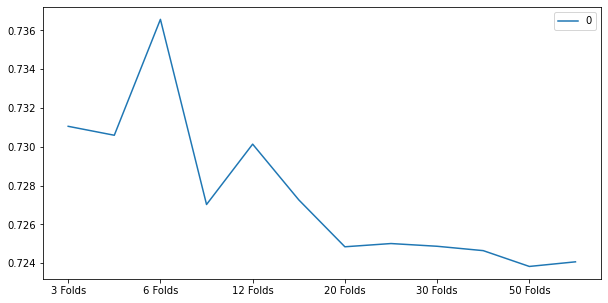

In [5]:
data = pd.DataFrame.from_dict(fold_results, orient='index')
data.plot(figsize=(10, 5))